# Traitement des images et vérification

In [1]:
# en tête
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import imageio
import sys, os

left = 4
top = 4
width = 128
height = 128

In [2]:
# séparer une chaîne de caractère en deux au niveau de l'espace
def txtsplit(mess):
    left = []
    while mess[0] != " ":
        left.append(mess[0])
        mess = mess[1:]
    return left,mess[1:]

In [3]:
# Supprime tous les fichiers d'un dossier
def removeall(path):

    if not os.path.isdir(path):
        return
    
    files=os.listdir(path)

    for x in files:
        fullpath=os.path.join(path, x)
        if os.path.isfile(fullpath):
            os.remove(fullpath)

## Dessin des contours filiformes

Récupère les contours sous format .ctr dans le dossier Documents/Images et enregistre les contours filiformes dans le fichier Images/128_contours_line en les redimensionnant au format 128x128

In [3]:
list_images = open("Documents/Images/liste", "r",encoding="utf8", errors='ignore')
name_images =list_images.readlines()
for im in name_images[1142:1415]:
    name = ''.join(im[:6])
    #Chargement de l'image graphique
    img = Image.new('RGB', (136, 136), color = 'white')
    fic = open("Documents/Images/" + name + ".ctr", "r",encoding="utf8", errors='ignore')
    lines = fic.readlines()
    long = len(lines)
    
    if long > 23:
        i = 0
        while (i<long) and (lines[i][0] != "t") :
            i+=1
        i+=23
        
    if i < long:
        nombre_points = 0
        #tracé de points
        while lines[i][0] != "-":
            z,t = txtsplit(lines[i])
            x = round(float(''.join(z)))
            y = round(float(''.join(t)))
            img.putpixel((x,y),(0,0,0))
            draw = ImageDraw.Draw(img)
            if nombre_points > 0:
                draw.line((x_prec, y_prec,x,y), fill="black")
            i +=1
            x_prec , y_prec = x,y
            nombre_points +=1
      
    box = (left, top, left+width, top+height)

    area = img.crop(box)
    area.save("Images/128_contours_line/" + name + ".png", "PNG")      
list_images.close()

## Redimensionnement des images

Redimensionnement des images IRM au format 128x128 et enregistrement dans le dossier Images/128_sized

In [13]:
list_images = open("Documents/Images/liste", "r",encoding="utf8", errors='ignore')
name_images =list_images.readlines()

for im in name_images[1142:1415]: #selection des images contourees
    name = ''.join(im[:6])
    im = Image.open("Documents/Images/" + name + ".pgm")
    
    box = (left, top, left+width, top+height)
    area = im.crop(box)
    
    area.save("Images/128_sized/" + name + ".png", "PNG")

# Enregistrement des images d'entrainement du modele Ultrasound

In [6]:
#Nombre d'images sur lesquelles s'entrainer à partir de la première séquence d'images (272 images max)

num_imgs = 272
num_img_max = len(os.listdir("Images/128_contours_line/"))
if num_imgs <1 or num_imgs>num_img_max:
    print("Nombre d'images d'entrainement demandé invalide!!\n ")

## Masques 

Copie au bon format des contours depuis Images/128_contours_line vers le dossier de training

In [5]:
#Effacement des fichiers de training
removeall("UltrasoundImageSegmentation/ultrasound segmentation-Single image/train/")

list_images = open("Documents/Images/liste", "r",encoding="utf8", errors='ignore')
name_images =list_images.readlines()
i = 0
for im in name_images[1142:1142 + num_imgs]:
    name = ''.join(im[:6])
    im = Image.open("Images/128_contours_line/" + name + ".png")
    
    im.save("UltrasoundImageSegmentation/ultrasound segmentation-Single image/train/" + str(i) + "_mask.tif", "PNG")
    i += 1

## Images IRM

Copie au bon format des images depuis Images/128_sized vers le dossier de training

In [6]:
#removeall("UltrasoundImageSegmentation/ultrasound segmentation-Single image/train/")

list_images = open("Documents/Images/liste", "r",encoding="utf8", errors='ignore')
name_images =list_images.readlines()
i = 0
for im in name_images[1142:1142 + num_imgs]:
    name = ''.join(im[:6])
    im = Image.open("Images/128_sized/" + name + ".png")
    
    im.save("UltrasoundImageSegmentation/ultrasound segmentation-Single image/train/" + str(i) + ".tif", "PNG")
    i += 1

## Ajout des images et des masques provenant d'une autre séquence 

Copie des images et contours issus d'une autre séquence d'images vers le dossier de training (attention, il n'y a pas à modifier le format ici car le dossier est déjà arrangé pour l'entraînement)

In [7]:
import shutil
way_of_images = "Images/8066_0011_contours1/"
way_of_training = "UltrasoundImageSegmentation/ultrasound segmentation-Single image/train/"
files = os.listdir(way_of_images)

for file in files:
    shutil.copy(way_of_images +file, way_of_training + file)

## Images de test

Il est nécessaire d'enregistrer un lot d'images de test dans le sous-dossier test, ici une centaine d'images suffit. J'ai choisi de manière arbitraire les images numérotées de 1800 à 1900 dans la première séquence.

In [27]:
j = 0
for i in range(1800,1901): #100 images de maniere arbitraire
    im = Image.open("UltrasoundImageSegmentation/ultrasound segmentation-Single image/test/i-" + str(i) + ".png")
    im.save("UltrasoundImageSegmentation/ultrasound segmentation-Single image/test/" + str(j) + ".tif", "PNG")
    j+=1

# Data Augmentation

## Translation

Translation des images et des masques puis enregistrement dans le dossier Images/translations_contours
Il reste à les mettre dans le dossier de training si nécessaire

In [31]:
from PIL import Image,ImageFilter

trans = (20,20)

list_images = open("Documents/Images/liste", "r",encoding="utf8", errors='ignore')
name_images =list_images.readlines()
for im in name_images[1142:1415]:
    name = ''.join(im[:6])
    im = Image.open("Images/128_sized/" + name + ".png")
    mask = Image.open("Images/128_contours_line/" + name + ".png")
    img = im.rotate(0,translate=trans)
    Mask = mask.rotate(0,translate=trans)
    img.save("Images/translations/trs_" + name + ".png")
    
    taille = Mask.size[0]

    #etape de remise de blanc sur le masque
    
    for i in range(taille):
        for j in range(20):
            Mask.putpixel((i,j),(255,255,255))
            Mask.putpixel((j,i),(255,255,255))
        
    Mask.save("Images/translations_contours/trs_" + name + ".png")

## Vérification: Superposition image/masque

Visualisation d'un contour généré en sortie du réseau sur l'image d'origine (les images de sortie sont enregistrées dans le sous-dossier **model_outputs** avec leurs masques comportant le numéro du checkpoint utilisé sous la forme "nom_image - num_checkpoint _mask.png"

In [13]:

def superpose(image, masque):
    
    foreground = Image.open(masque).convert("RGB")
    
    background = Image.open(image).convert("RGB")
    img = Image.blend(background,foreground,0.5)
    
    plt.imshow(img)
    plt.show()
    img.save("Documents/Rapport/4.png")

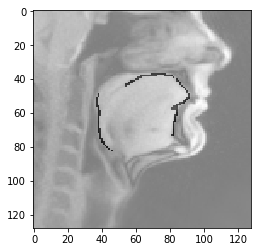

In [14]:
superpose("UltrasoundImageSegmentation/ultrasound segmentation-Single image/model_outputs/i-0026.png","UltrasoundImageSegmentation/ultrasound segmentation-Single image/model_outputs/i-0026-6000_mask.png")
#superpose("UltrasoundImageSegmentation/ultrasound segmentation-Single image/model_outputs/i-2000.png","UltrasoundImageSegmentation/ultrasound segmentation-Single image/model_outputs/i-2000-6000_mask.png")

## Vérification manuelle

In [4]:
# évaluation de la similarité entre un masque et la prédiction du réseau
def similarity(mask,predicted):
    #ouverture des images
    mat1 = imageio.imread(mask,as_gray=True)
    mat2 = imageio.imread(predicted,as_gray=True)
    
    long = len(mat1)
    # comparaison des pixels
    inter = 0            #Cardinal of the intersection
    card_predicted = 0   #Cardinal of the predicted image
    for i in range(long):
        for j in range(long):
            if(int(mat2[i][j]) == 0):
                card_predicted += 1
                if(int(mat1[i][j]) == 0):
                    inter += 1
    return inter/card_predicted

In [5]:
# calcul du nombre d'itérations du modèle maximisant la moyenne des similarités pour tous les checkpoints
def validation_test():
    list_images = os.listdir('test_num_epoch/')
    number_of_images = len(list_images)
    step_max = 6750
    gap = 250
    number_of_ckpt = int(step_max / gap) + 1
    similarities = np.zeros((number_of_ckpt,number_of_images))
    for i in range(number_of_ckpt):
        num_ckpt = i * gap
        for j in range(number_of_images):
            im = list_images[j]
            mask = "/home/alexis/Images/128_contours_line/" + im
            predicted = "model_outputs/test-nepoch/" + im[:-4] + "-" + str(num_ckpt) + "_mask.png"
            similarities[i][j] = similarity(mask,predicted)
    mean = np.apply_along_axis(np.mean,1,similarities) #compute the mean of each checkpoint in an array
    similarity_max = np.where(mean == np.amax(mean))[0] #calculate the index of max similarity
    return similarity_max*gap

In [ ]:
validation_test()